# <center> Jordan Hall and Dan Bielich: Group HW1 continued: Problem 3
    
### NOTE: All computations below were performed on 2 processors only.

# Student to-do's
---

1. Parallelize the necessary cells in this notebook so that the assembly calls involving the convolutions can be spread out among multiple processors. 


2. Use a 50x50 mesh and `eps=[0.2, 0.1, 0.05]` to compute $L^2$ errors and plot errors vs `eps`. Also, compute $L^\infty$ errors and plot vs `eps`. Also, create tables for these error plots. All of this should be done after parallelization.


3. Re-do step 2 with the "compact" mesh (i.e., the compactly contained submesh). 

In [1]:
import ipyparallel as ipp
#rc = ipp.Client(profile='mpi') #only if you have setup a profile with ipcluster called mpi
rc = ipp.Client()
view = rc[:]
print(view)

<DirectView [0, 1]>


In [2]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

## Setup the local environment.

### Load the libraries and create the meshes and function spaces for plotting

In [3]:
#Setup local environment libraries and also the list of processors on the cluster that we can access 

import numpy as np
import dolfin as fn

import scipy.io as sio #for the i/o

import time #to wait between checking if jobs are done

procs = np.array(rc.ids) #get list of processors on cluster that local environment can access
print(procs)

import ipywidgets as wd

from matplotlib import pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

[0 1]


In [4]:
# Create meshes and define function spaces in local environment
grid_x = 50
grid_y = 50
mesh = fn.UnitSquareMesh(grid_x, grid_y, 'left')
V1 = fn.FunctionSpace(mesh, "Lagrange", 1)

coors=mesh.coordinates()

eps=0.1
x0 = max([eps, 0.2])
y0 = max([eps, 0.2])
x1 = 1 - max([eps, 0.2])
y1 = 1 - max([eps, 0.2])
mesh_compact = fn.RectangleMesh(fn.Point(x0, y0), fn.Point(x1, y1), grid_x, grid_y, 'left')
V_compact = fn.FunctionSpace(mesh_compact, "Lagrange", 1)

In [5]:
# Setup the functions we consider in the local environment

# The sines function
xn = 3
ym = 2

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)
u_sines_exact_eval = fn.interpolate(u_sines_exact, V_compact)


# The discontinuous function
class U_discontinuous(fn.UserExpression):
    def __init__(self, a, b, **kwargs):
        self.a = a
        self.b = b
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = 0
        if (x[0] > self.a) & (x[1] > self.b):
            v[0] = 1
        return v
    def value_shape(self):
        return ()
    
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V1)
u_discontinuous_exact_eval = fn.interpolate(u_discontinuous_exact, V_compact)

## Now setup the environment on each processor in the cluster and the convolution function 

In [6]:
%%px
#Setup environment on each processor in cluster

import numpy as np
import dolfin as fn
import scipy.io as sio

In [7]:
%%px

def CreateSmoothFunctions(proc_num, proc_max, grid_x=50, grid_y=50, eps=0.1):
    
    mesh = fn.UnitSquareMesh(grid_x, grid_y, 'left')
    V1 = fn.FunctionSpace(mesh, "Lagrange", 1)

    coors=mesh.coordinates()
    
    # The sines function
    xn = 3
    ym = 2

    u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

    # The discontinuous function
    class U_discontinuous(fn.UserExpression):
        def __init__(self, a, b, **kwargs):
            self.a = a
            self.b = b
            super().__init__(**kwargs)
        def eval(self, v, x):
            v[0] = 0
            if (x[0] > self.a) & (x[1] > self.b):
                v[0] = 1
            return v
        def value_shape(self):
            return ()

    u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V1)

    class Mollifier(fn.UserExpression):
        def __init__(self, x_pt, eps, C, **kwargs):
            self.x0 = x_pt[0]
            self.x1 = x_pt[1]
            self.eps = eps
            self.C = C
            super().__init__(**kwargs)
        def eval(self, v, x):
            v[0] = 0
            a = ( (x[0]-self.x0)**2+(x[1]-self.x1)**2 ) / eps**2
            if (a < 1):
                v[0] = (1/self.C) * fn.exp( 1 / (a-1) ) / eps**2
            return v
        def value_shape(self):
            return ()

    C = fn.assemble( fn.interpolate(Mollifier([0.5, 0.5], eps, 1, degree=10), V1)*fn.dx ) #The normalizing constant

    mollifier = fn.interpolate(Mollifier([0.5, 0.5], eps, C, degree=10), V1) #The actual mollifier
    
    u_sine_smooth_vals = np.zeros(coors[:,0].size)
    u_disc_smooth_vals = np.zeros(coors[:,0].size)
    
    num_coors = coors[:,0].size
    num_coors_per_proc = num_coors // proc_max
    
    if proc_num<proc_max:
        for i in range(proc_num*num_coors_per_proc, (proc_num+1)*num_coors_per_proc):
            u_sine_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) *
                                             u_sines_exact * fn.dx)
            u_disc_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) *
                                             u_discontinuous_exact * fn.dx)
    else:
        for i in range(proc_num*num_coors_per_proc, num_coors):
            u_sine_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) *
                                             u_sines_exact * fn.dx)
            u_disc_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) *
                                             u_discontinuous_exact * fn.dx)
        
    filename = 'work/u_func_smooth_proc_' + str(proc_num) + '.mat' 
    data_dict = {'sine_smooth_vals': u_sine_smooth_vals, 'disc_smooth_vals': u_disc_smooth_vals}
    sio.savemat(filename, data_dict)
    return

## Now send jobs to each processor in the cluster to perform the convolution (data is written to files)

# $\epsilon$ = .1

In [8]:
view.push(dict(procs=procs))

async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.1), range(procs.size) ) 



In [9]:
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - GO GRAB A COLD BEVERAGE TO PASS THE TIME!

In [10]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [12]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh).reshape((grid_x+1, grid_y+1))

Flushing output cache (1 entries)


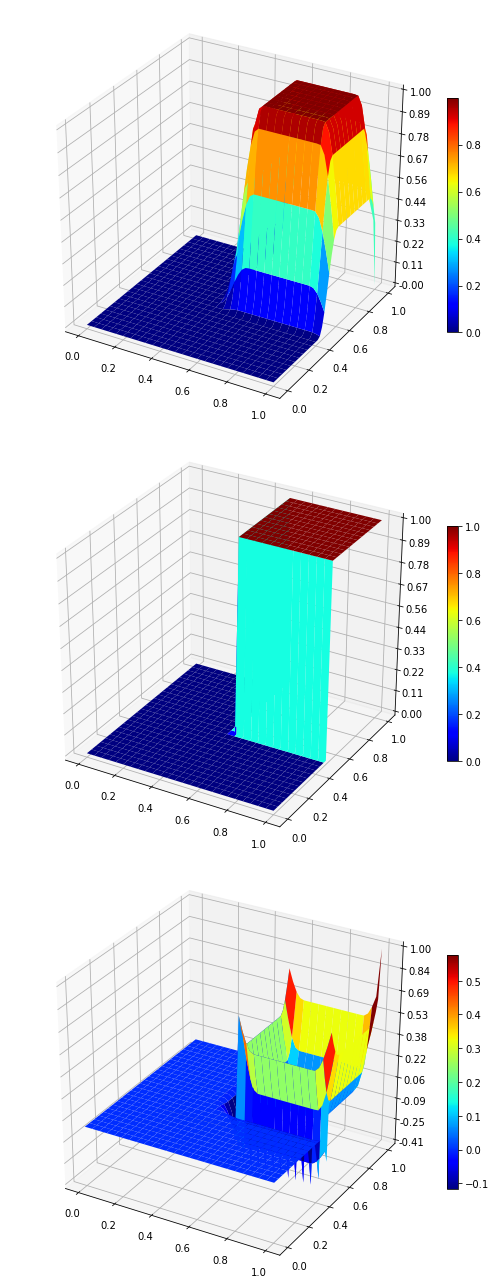

In [13]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


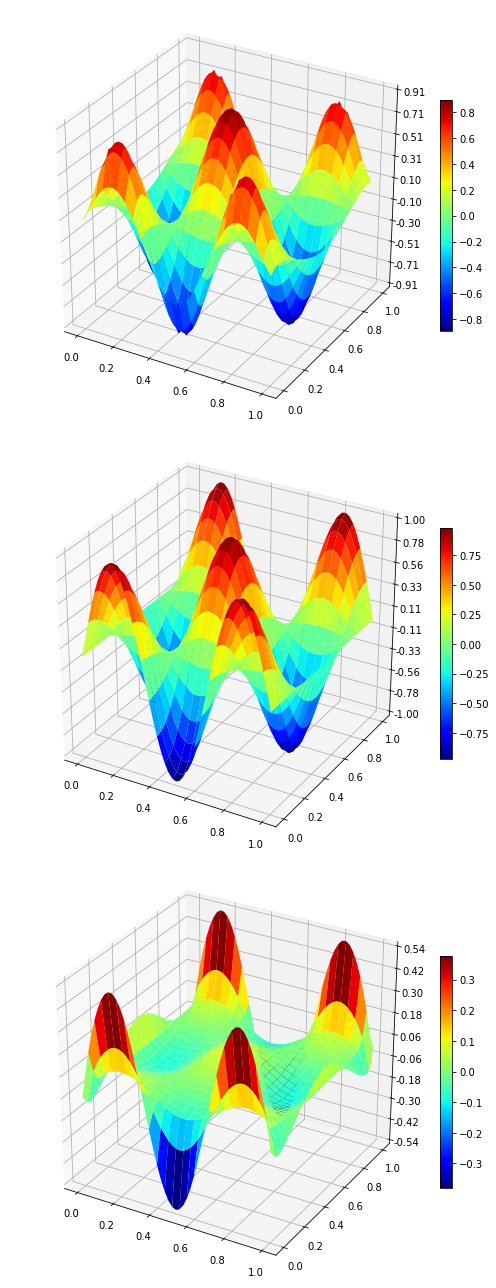

In [14]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)

Something to check-out: https://github.com/mikaem/fenicstools/wiki/DofMap-plotter

In [15]:
# Let's understand some maps between the mesh and the function space degrees of freedom

dofs_coordinates = V1.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V1)
v2d_map = fn.vertex_to_dof_map(V1)
print(d2v_map[0:10])
print()
print(v2d_map[0:10])
print()
print(dofs_coordinates[0:10,:])
print()
print(mesh.coordinates()[0:10,:])
print()
print(mesh.coordinates()[d2v_map[0:10],:])

[2600 2549 2599 2498 2548 2598 2447 2497 2547 2597]

[2600 2598 2595 2591 2586 2580 2573 2565 2556 2546]

[[1.   1.  ]
 [1.   0.98]
 [0.98 1.  ]
 [1.   0.96]
 [0.98 0.98]
 [0.96 1.  ]
 [1.   0.94]
 [0.98 0.96]
 [0.96 0.98]
 [0.94 1.  ]]

[[0.   0.  ]
 [0.02 0.  ]
 [0.04 0.  ]
 [0.06 0.  ]
 [0.08 0.  ]
 [0.1  0.  ]
 [0.12 0.  ]
 [0.14 0.  ]
 [0.16 0.  ]
 [0.18 0.  ]]

[[1.   1.  ]
 [1.   0.98]
 [0.98 1.  ]
 [1.   0.96]
 [0.98 0.98]
 [0.96 1.  ]
 [1.   0.94]
 [0.98 0.96]
 [0.96 0.98]
 [0.94 1.  ]]


In [16]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V1 = fn.Function(V1)
u_disc_smooth_V1.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V1 = fn.Function(V1)
u_sine_smooth_V1.vector()[:] = u_sine_smooth_vec[d2v_map]

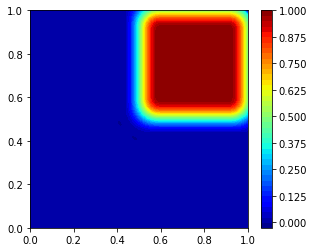

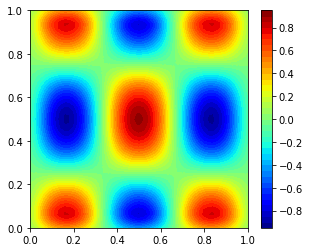

In [17]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V1)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V1)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [25]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V1)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V1-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V1-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V1-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V1-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.10733504883537684
L2         error of smooth sine:            0.09143101916417752
L^{\infty} error of smooth characteristic:  0.037902855433086
L^{\infty} error of smooth sine:            0.05381781516961219


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .1 | .091 | .054 |
|  Characteristic | .1 | .107 | .038 |

# $\epsilon$ = .2


In [27]:
view.push(dict(procs=procs))
async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.2), range(procs.size) ) 
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - GO GRAB A COLD BEVERAGE TO PASS THE TIME!

In [28]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(10 + i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [30]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh).reshape((grid_x+1, grid_y+1))

Flushing output cache (2 entries)


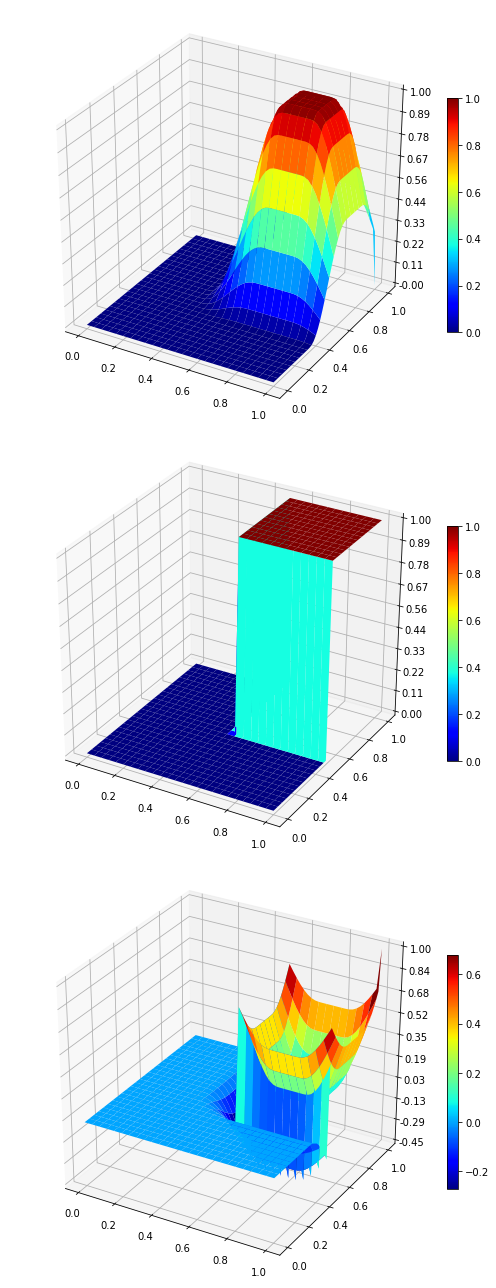

In [31]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


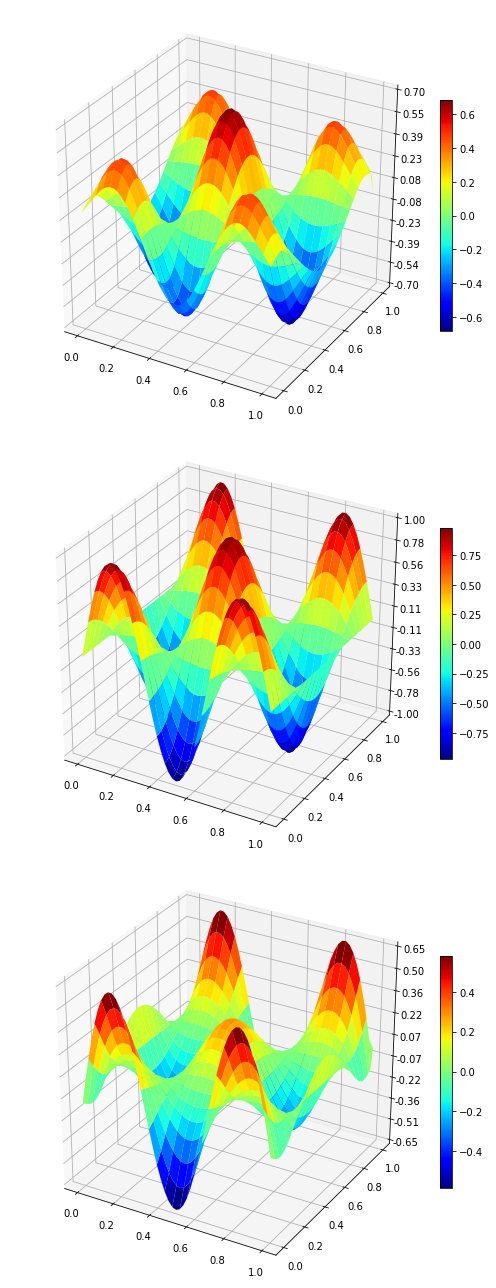

In [32]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)


In [33]:
dofs_coordinates = V1.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V1)
v2d_map = fn.vertex_to_dof_map(V1)

In [34]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V1 = fn.Function(V1)
u_disc_smooth_V1.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V1 = fn.Function(V1)
u_sine_smooth_V1.vector()[:] = u_sine_smooth_vec[d2v_map]

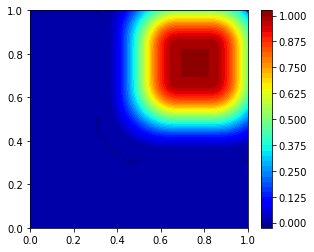

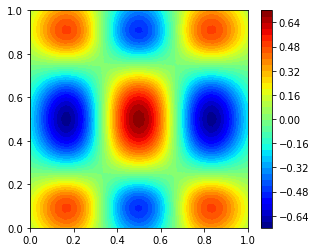

In [35]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V1)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V1)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [36]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V1)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V1-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V1-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V1-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V1-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.16163554186893556
L2         error of smooth sine:            0.1977365238396294
L^{\infty} error of smooth characteristic:  0.07692462915759753
L^{\infty} error of smooth sine:            0.1465455719326632


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .2 | .198 | .147 |
|  Characteristic | .2 | .162 | .077 |

# $\epsilon$ = .05


In [38]:
view.push(dict(procs=procs))
async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.05), range(procs.size) ) 
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - GO GRAB A COLD BEVERAGE TO PASS THE TIME!

In [48]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [49]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh).reshape((grid_x+1, grid_y+1))

Flushing output cache (1 entries)


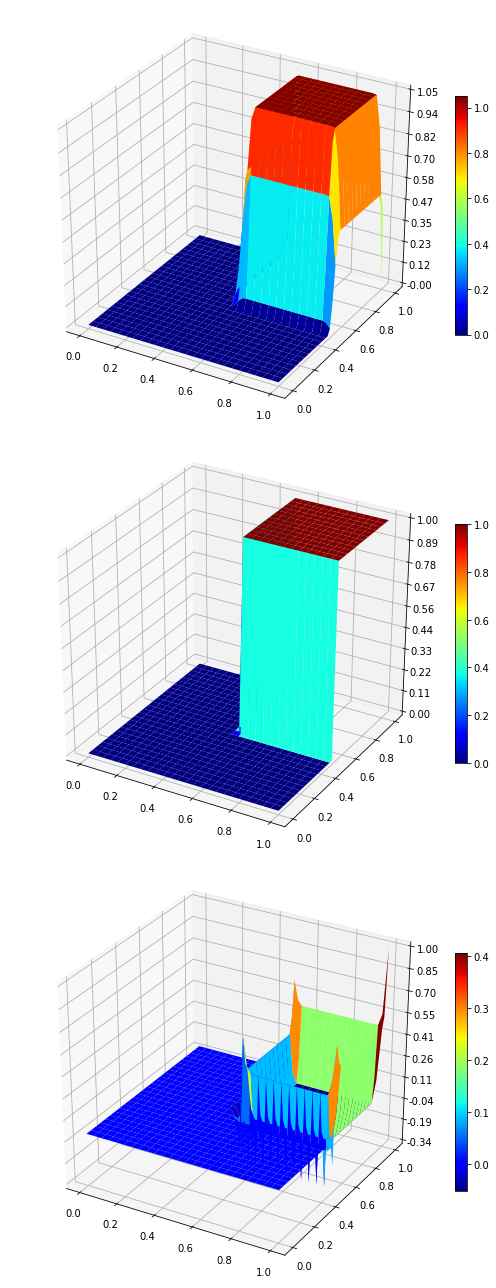

In [50]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


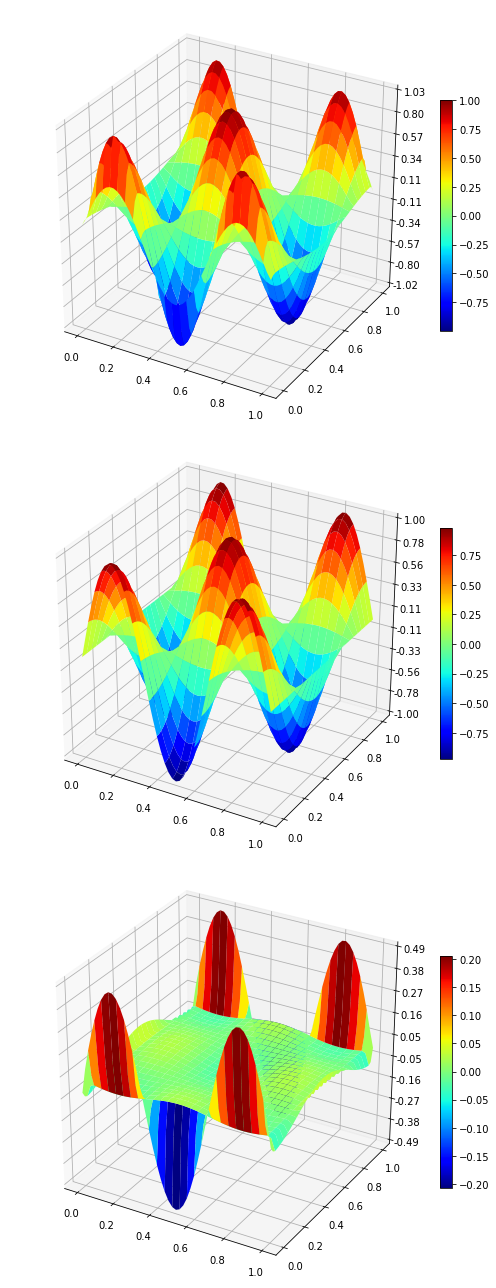

In [51]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)


In [52]:
dofs_coordinates = V1.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V1)
v2d_map = fn.vertex_to_dof_map(V1)

In [53]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V1 = fn.Function(V1)
u_disc_smooth_V1.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V1 = fn.Function(V1)
u_sine_smooth_V1.vector()[:] = u_sine_smooth_vec[d2v_map]

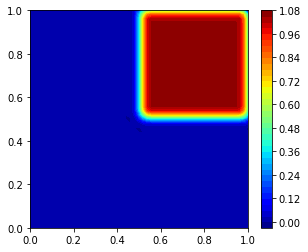

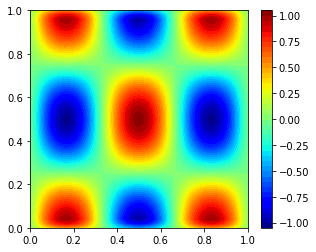

In [54]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V1)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V1)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [55]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V1)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V1-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V1-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V1-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V1)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V1-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.06852161996850654
L2         error of smooth sine:            0.04928498235511006
L^{\infty} error of smooth characteristic:  0.02446903299172645
L^{\infty} error of smooth sine:            0.019672648602354854


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .05 | .049 | .020 |
|  Characteristic | .05 | .069 | .024 |


___

# <center> Now the same but on a compact mesh

# $\epsilon$ = .1

In [87]:
view.push(dict(procs=procs))

async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.1), range(procs.size) ) 

In [88]:
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - GO GRAB A COLD BEVERAGE TO PASS THE TIME!

In [89]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [90]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1, grid_y+1))

Flushing output cache (2 entries)


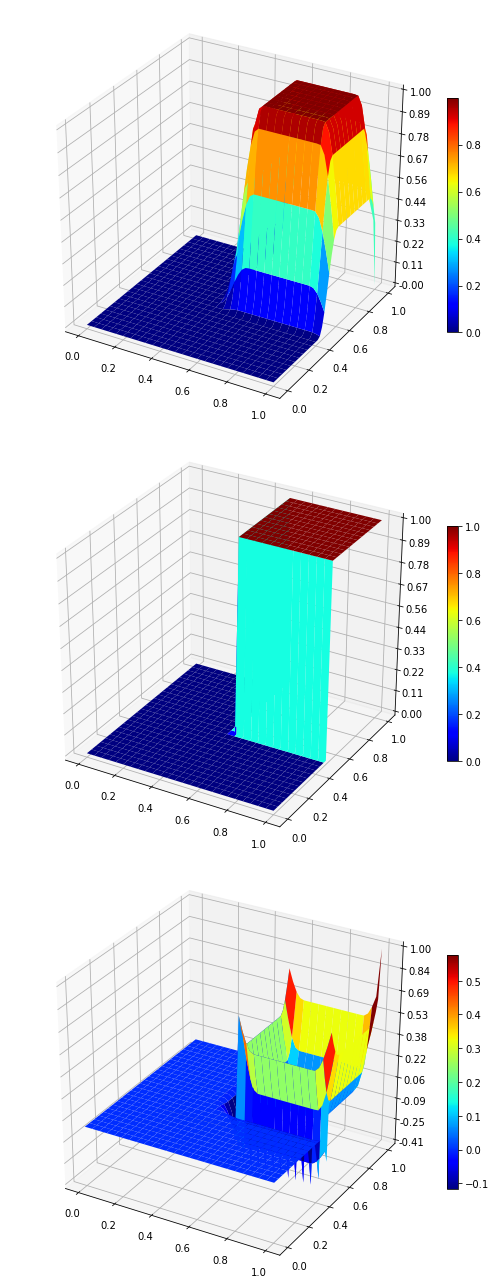

In [91]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


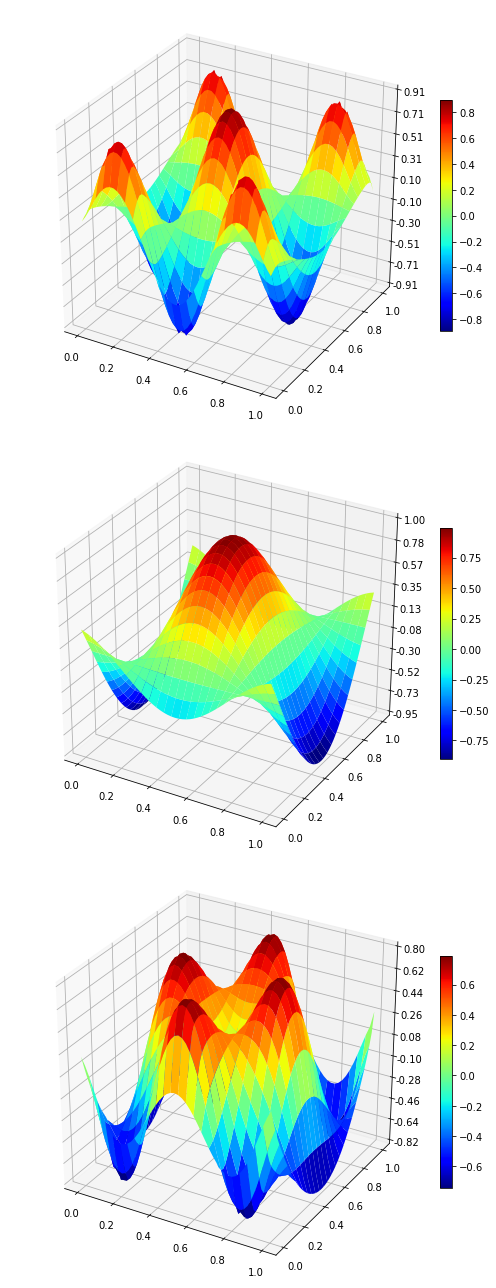

In [92]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)

Something to check-out: https://github.com/mikaem/fenicstools/wiki/DofMap-plotter

In [93]:
# Let's understand some maps between the mesh and the function space degrees of freedom

dofs_coordinates = V_compact.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V_compact)
v2d_map = fn.vertex_to_dof_map(V_compact)
print(d2v_map[0:10])
print()
print(v2d_map[0:10])
print()
print(dofs_coordinates[0:10,:])
print()
print(mesh_compact.coordinates()[0:10,:])
print()
print(mesh_compact.coordinates()[d2v_map[0:10],:])

[2600 2549 2599 2498 2548 2598 2447 2497 2547 2597]

[2600 2598 2595 2591 2586 2580 2573 2565 2556 2546]

[[0.8   0.8  ]
 [0.8   0.788]
 [0.788 0.8  ]
 [0.8   0.776]
 [0.788 0.788]
 [0.776 0.8  ]
 [0.8   0.764]
 [0.788 0.776]
 [0.776 0.788]
 [0.764 0.8  ]]

[[0.2   0.2  ]
 [0.212 0.2  ]
 [0.224 0.2  ]
 [0.236 0.2  ]
 [0.248 0.2  ]
 [0.26  0.2  ]
 [0.272 0.2  ]
 [0.284 0.2  ]
 [0.296 0.2  ]
 [0.308 0.2  ]]

[[0.8   0.8  ]
 [0.8   0.788]
 [0.788 0.8  ]
 [0.8   0.776]
 [0.788 0.788]
 [0.776 0.8  ]
 [0.8   0.764]
 [0.788 0.776]
 [0.776 0.788]
 [0.764 0.8  ]]


In [94]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V_compact = fn.Function(V_compact)
u_disc_smooth_V_compact.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V_compact = fn.Function(V_compact)
u_sine_smooth_V_compact.vector()[:] = u_sine_smooth_vec[d2v_map]

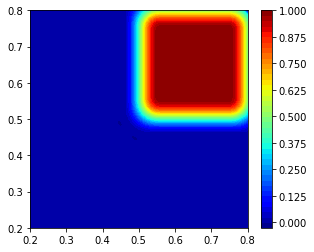

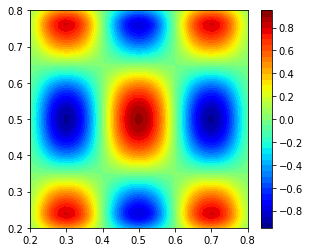

In [95]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V_compact)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V_compact)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [96]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V_compact)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V_compact-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V_compact-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V_compact-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V_compact-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.0644010293012258
L2         error of smooth sine:            0.2772484350707278
L^{\infty} error of smooth characteristic:  0.01364502795591083
L^{\infty} error of smooth sine:            0.1488060956673826


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .1 | .277 | .149 |
|  Characteristic | .1 | .064 | .014 |

# $\epsilon$ = .2


In [75]:
view.push(dict(procs=procs))
async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.2), range(procs.size) ) 
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - GO GRAB A COLD BEVERAGE TO PASS THE TIME!

In [76]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [80]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1, grid_y+1))

Flushing output cache (0 entries)


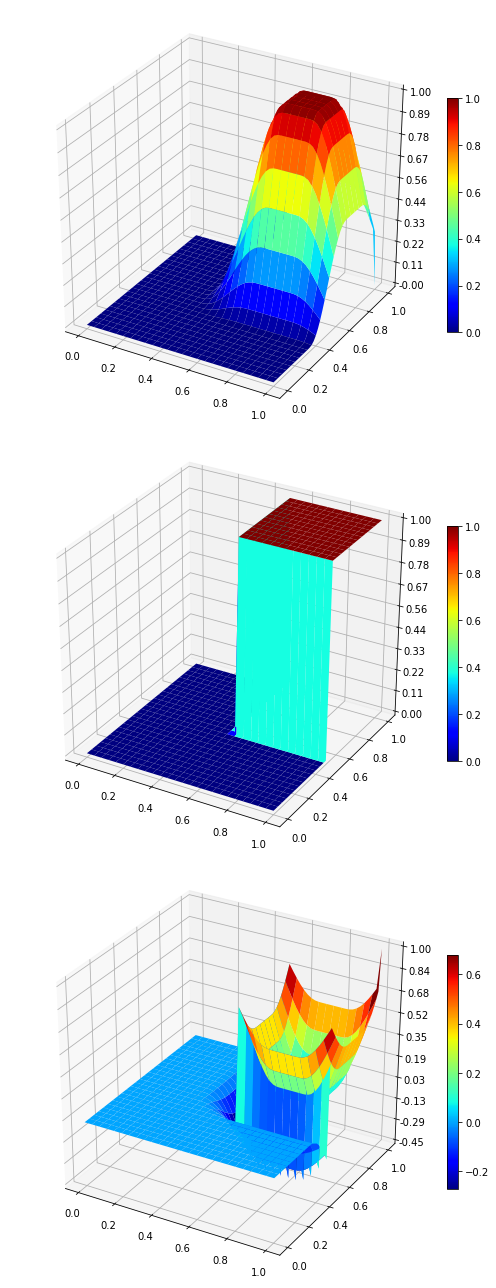

In [81]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


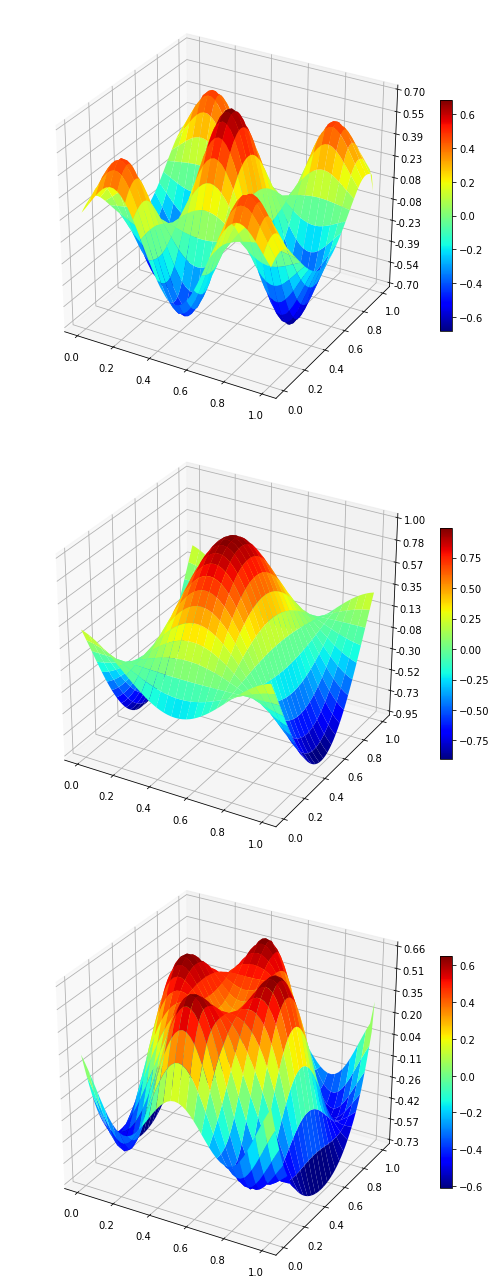

In [82]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)


In [83]:
dofs_coordinates = V_compact.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V_compact)
v2d_map = fn.vertex_to_dof_map(V_compact)

In [84]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V_compact = fn.Function(V_compact)
u_disc_smooth_V_compact.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V_compact = fn.Function(V_compact)
u_sine_smooth_V_compact.vector()[:] = u_sine_smooth_vec[d2v_map]

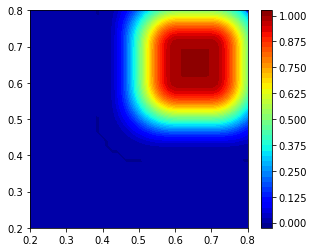

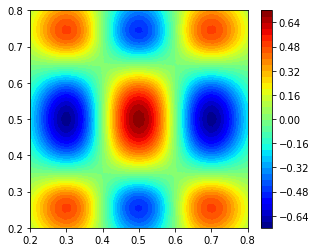

In [85]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V_compact)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V_compact)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [86]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V_compact)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V_compact-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V_compact-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V_compact-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V_compact-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.09698132512136126
L2         error of smooth sine:            0.23979128897497015
L^{\infty} error of smooth characteristic:  0.027692866496735077
L^{\infty} error of smooth sine:            0.1297870447156876


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .2 | .240 | .130 |
|  Characteristic | .2 | .097 | .028 |

# $\epsilon$ = .05


In [97]:
view.push(dict(procs=procs))
async_process = view.map_async(lambda proc_num: CreateSmoothFunctions(proc_num, proc_max=procs.size, eps=0.05), range(procs.size) ) 
async_process.error

[None, None]

## Check if jobs are done yet and then load data for smoothed functions

# THIS IS THE SLOW CELL - 5 "cold beverages" is a lot... maybe just watch some TV?

In [98]:
done = False
while done == False:
    if async_process.done():
        done = True
        print('Now we can load in the data')
    else:
        time.sleep(1)

u_sine_smooth_vals = np.zeros(coors[:,0].size)
u_disc_smooth_vals = np.zeros(coors[:,0].size)

for i in range(procs.size):
    filename = '/home/jovyan/work/u_func_smooth_proc_' + str(i) + '.mat' 
    partial_data = sio.loadmat(filename)
    u_sine_smooth_vals += partial_data['sine_smooth_vals'].reshape(coors[:,0].size)
    u_disc_smooth_vals += partial_data['disc_smooth_vals'].reshape(coors[:,0].size)

Now we can load in the data


## Now for plotting and computing errors just as before.

In [99]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = u_discontinuous_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1,grid_y+1))

u_sine_smooth_vals = u_sine_smooth_vals.reshape((grid_x+1,grid_y+1))
u_sine_exact_vals = u_sines_exact.compute_vertex_values(mesh_compact).reshape((grid_x+1, grid_y+1))

Flushing output cache (2 entries)


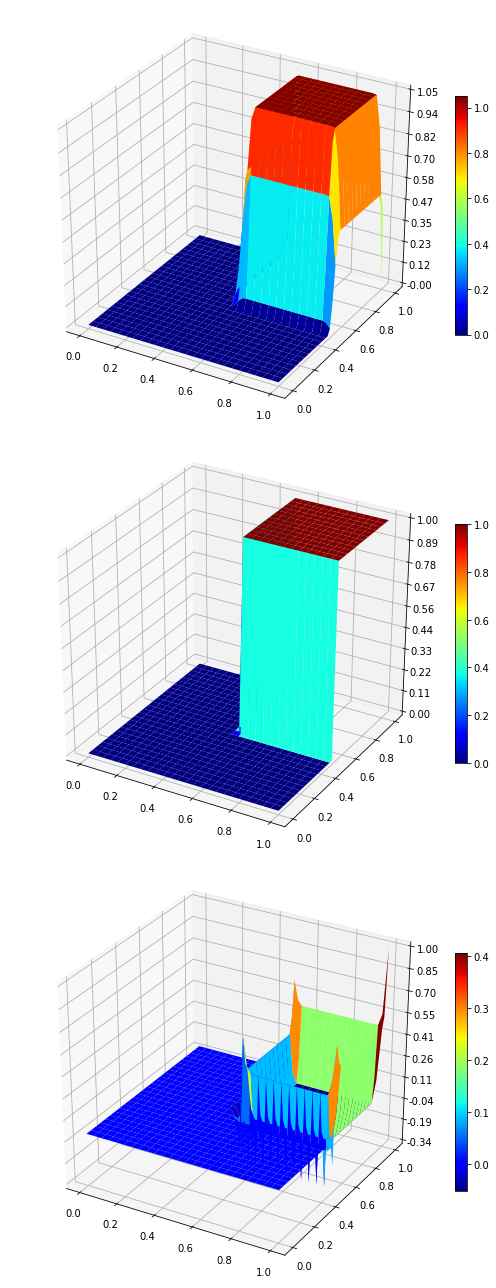

In [100]:
%reset -f out

fig = plt.figure(figsize=(7,18))

ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_exact_vals - u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

Flushing output cache (0 entries)


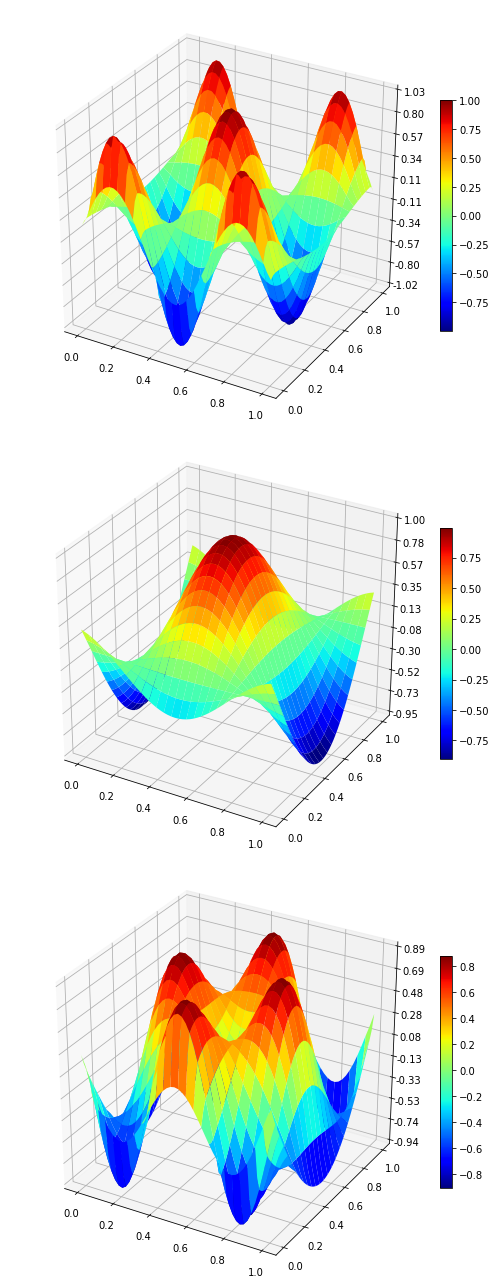

In [101]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,2, projection='3d')
# Plot the exact surface
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()

ax = plt.subplot(3,1,3, projection='3d')
# Plot the error
surf = ax.plot_surface(mesh_X, mesh_Y, u_sine_exact_vals - u_sine_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Let's see how to move function values defines on the mesh coordinates back to the function object (not as straightforward as you would hope but not too bad)


In [102]:
dofs_coordinates = V_compact.tabulate_dof_coordinates()
d2v_map = fn.dof_to_vertex_map(V_compact)
v2d_map = fn.vertex_to_dof_map(V_compact)

In [103]:
#Reshape from 2D to a 1D vector
u_disc_smooth_vec = u_disc_smooth_vals.reshape((grid_x+1)*(grid_y+1))
u_sine_smooth_vec = u_sine_smooth_vals.reshape((grid_x+1)*(grid_y+1))

u_disc_smooth_V_compact = fn.Function(V_compact)
u_disc_smooth_V_compact.vector()[:] = u_disc_smooth_vec[d2v_map]

u_sine_smooth_V_compact = fn.Function(V_compact)
u_sine_smooth_V_compact.vector()[:] = u_sine_smooth_vec[d2v_map]

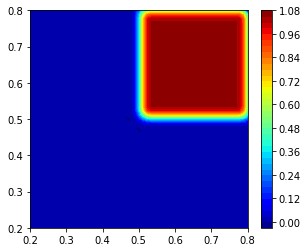

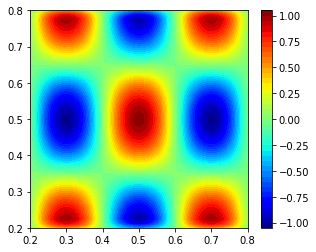

In [104]:
fig = plt.figure()
disc_plot = fn.plot(u_disc_smooth_V_compact)
disc_plot.set_cmap("jet")
plt.colorbar(disc_plot,fraction=0.046, pad=0.04)

fig = plt.figure()
sine_plot = fn.plot(u_sine_smooth_V_compact)
sine_plot.set_cmap("jet")
plt.colorbar(sine_plot,fraction=0.046, pad=0.04)

In [105]:
u_discontinuous_exact = fn.interpolate(U_discontinuous(a=0.5,b=0.5,degree=1), V_compact)

print('L2         error of smooth characteristic: ', 
      fn.sqrt(fn.assemble((u_disc_smooth_V_compact-u_discontinuous_exact)**2*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L2         error of smooth sine:           ', 
      fn.sqrt(fn.assemble((u_sine_smooth_V_compact-u_sines_exact)**2*fn.dx))
     )

print('L^{\infty} error of smooth characteristic: ', 
      np.max(fn.assemble(abs(u_disc_smooth_V_compact-u_discontinuous_exact)*fn.dx))
     )

u_sines_exact = fn.interpolate(fn.Expression('sin(xn*pi*x[0])*cos(ym*pi*x[1])', xn=xn, ym=ym, degree=2), V_compact)

print('L^{\infty} error of smooth sine:           ', 
      np.max(fn.assemble(abs(u_sine_smooth_V_compact-u_sines_exact)*fn.dx))
     )

L2         error of smooth characteristic:  0.04111297198110401
L2         error of smooth sine:            0.3025683007889246
L^{\infty} error of smooth characteristic:  0.008808851877021595
L^{\infty} error of smooth sine:            0.15987171160267505


| Function | $\epsilon$ | $L^2$-error | $L^{\infty}$-error |
| --- | --- | --- | --- |
|  sine | .05 | .302 | .160 |
|  Characteristic | .05 | .041 | .009 |

## Plot Results!

### Full Mesh Results

In [129]:
# Define vectors with results for plotting

sin_L2=[.049,.091,.198]

char_L2=[.069, .107, .162]

sin_Linf=[.02, .054, .147]

char_Linf=[.024, .038, .077]

eps=[.05,.1,.2]

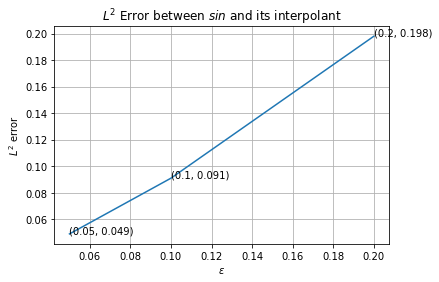

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, sin_L2)

for xy in zip(eps, sin_L2):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^2$ error')
plt.title('$L^2$ Error between $sin$ and its interpolant')

plt.grid()
plt.show()

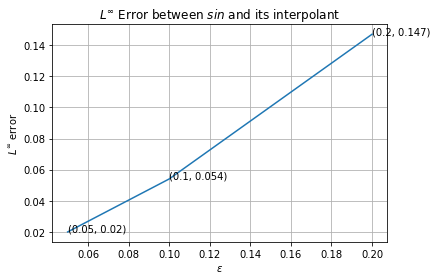

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, sin_Linf)

for xy in zip(eps, sin_Linf):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^\infty$ error')
plt.title('$L^\infty$ Error between $sin$ and its interpolant')

plt.grid()
plt.show()

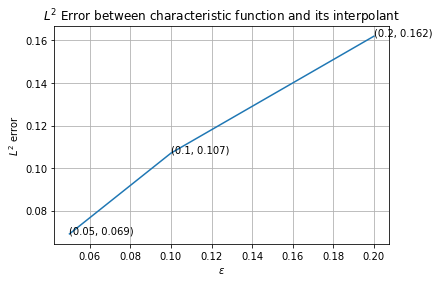

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, char_L2)

for xy in zip(eps, char_L2):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^2$ error')
plt.title('$L^2$ Error between characteristic function and its interpolant')

plt.grid()
plt.show()

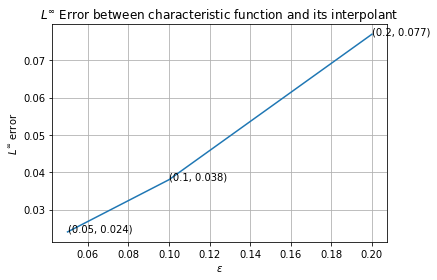

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, char_Linf)

for xy in zip(eps, char_Linf):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^\infty$ error')
plt.title('$L^\infty$ Error between characteristic function and its interpolant')

plt.grid()
plt.show()

### Compact Mesh Results

In [136]:
# Make more vectors for other results

Csin_L2=[.302, .277, .240]

Cchar_L2=[.041, .064, .097]

Csin_Linf=[.160, .149, .13]

Cchar_Linf=[.009, .014, .028]

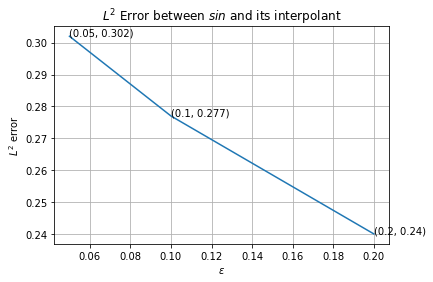

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, Csin_L2)

for xy in zip(eps, Csin_L2):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^2$ error')
plt.title('$L^2$ Error between $sin$ and its interpolant')

plt.grid()
plt.show()

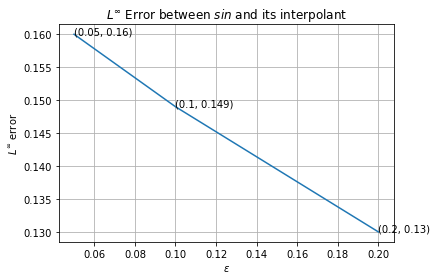

In [138]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, Csin_Linf)

for xy in zip(eps, Csin_Linf):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^\infty$ error')
plt.title('$L^\infty$ Error between $sin$ and its interpolant')

plt.grid()
plt.show()

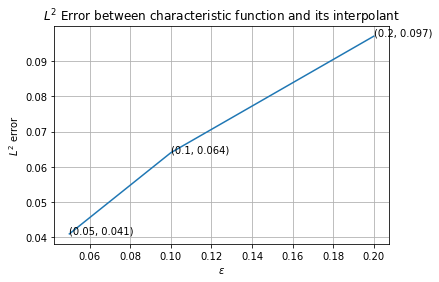

In [139]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, Cchar_L2)

for xy in zip(eps, Cchar_L2):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^2$ error')
plt.title('$L^2$ Error between characteristic function and its interpolant')

plt.grid()
plt.show()

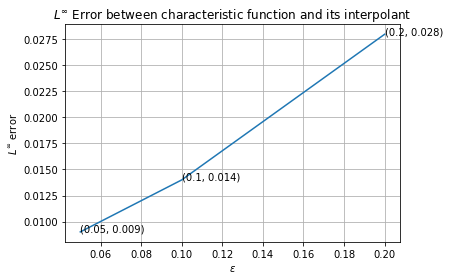

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(eps, Cchar_Linf)

for xy in zip(eps, Cchar_Linf):                             
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('$\epsilon$')
plt.ylabel('$L^\infty$ error')
plt.title('$L^\infty$ Error between characteristic function and its interpolant')

plt.grid()
plt.show()